# LGBM Regressor Baseline

*방향*

**농수축** 데이터에 대해 제공된 데이터에서 뽑아낼 수 있는 feature만 가지고 진행했을 때 어느 정도 맞는지 확인해 보자.

- train, test set split: cluster 기준 계층적 샘플링.
- 판매량을 넣었을 때, 안 넣었을 때 기준으로 MAPE 측정.

*문제*

- 군집을 반영해줄 수 없다!


*결과*

- 마더코드, 상품코드 반영했을 때 MAPE 스코어 0.37 정도.
- 마더코드, 상품코드 반영하지 않았을 때 MAPE 스코어 0.50 정도.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
# RAW_DATA = "./data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx"
RAW_DATA_EXPOSURE_FILLED = "./data/노출시간채운데이터.xlsx"
NSC_CLUSTERED_WITHOUT_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"
NSC_CLUSTERED_WITH_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"

In [3]:
data_raw = pd.read_excel(RAW_DATA_EXPOSURE_FILLED, usecols= lambda x: 'Unnamed' not in x)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    38309 non-null  datetime64[ns]
 1   노출(분)   38309 non-null  float64       
 2   마더코드    38309 non-null  int64         
 3   상품코드    38309 non-null  int64         
 4   상품명     38309 non-null  object        
 5   상품군     38309 non-null  object        
 6   판매단가    38309 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [4]:
data_nsc = data_raw[data_raw['상품군'] == '농수축']
print(data_nsc.info())
data_nsc['판매단가'].min(), data_nsc['판매단가'].max(), data_nsc['취급액'].min(), data_nsc['취급액'].max()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3884 entries, 29 to 38249
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    3884 non-null   datetime64[ns]
 1   노출(분)   3884 non-null   float64       
 2   마더코드    3884 non-null   int64         
 3   상품코드    3884 non-null   int64         
 4   상품명     3884 non-null   object        
 5   상품군     3884 non-null   object        
 6   판매단가    3884 non-null   int64         
 7   취급액     3884 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 273.1+ KB
None


(28900, 109900, 1292000.0, 270284000.0)

In [5]:
data = data_nsc.drop(columns=['상품군'], axis=1)
data = data.reset_index(drop=True)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0
...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0


# Feature 선택 1
- 월
- 일
- 요일
- 노출(분)
- 마더코드
- 상품코드
- 판매단가

In [6]:
# data['판매량'] = data['취급액'] / data['판매단가']
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액,월,일,요일
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0,1,1,화요일
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0,1,1,화요일
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0,1,1,화요일
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0,1,1,화요일
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0,1,1,화요일
...,...,...,...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0,12,31,화요일
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0,12,31,화요일
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0,12,31,화요일
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0,12,31,화요일


In [7]:
df = data[['월', '일', '요일', '노출(분)', '마더코드', '상품코드', '판매단가', '취급액']]
df.columns = ['month', 'day', 'weekday', 'exposure', 'mcode', 'pcode', 'price', 'sales']
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder

In [8]:
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,month,day,weekday,exposure,mcode,pcode,price,sales
0,1,1,6,20.0,100496,201497,60900,14113000.0
1,1,1,6,20.0,100496,201497,60900,32395000.0
2,1,1,6,20.0,100496,201497,60900,39669000.0
3,1,1,6,20.0,100322,201479,49900,60787000.0
4,1,1,6,20.0,100322,201479,49900,115457000.0
...,...,...,...,...,...,...,...,...
3879,12,31,6,20.0,100253,200864,30900,54879000.0
3880,12,31,6,20.0,100253,200864,30900,63460000.0
3881,12,31,6,20.0,100812,202397,49900,34001000.0
3882,12,31,6,20.0,100812,202397,49900,54234000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   month     3884 non-null   int64  
 1   day       3884 non-null   int64  
 2   weekday   3884 non-null   int32  
 3   exposure  3884 non-null   float64
 4   mcode     3884 non-null   int64  
 5   pcode     3884 non-null   int64  
 6   price     3884 non-null   int64  
 7   sales     3884 non-null   float64
dtypes: float64(2), int32(1), int64(5)
memory usage: 227.7 KB


In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['weekday']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

In [11]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

## 데이터셋 구성

In [12]:
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 파라미터 구성

### 파라미터 조합 1

In [14]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

In [15]:
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=1000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.457472
[200]	valid_0's mape: 0.411918
[300]	valid_0's mape: 0.394005
[400]	valid_0's mape: 0.386031
[500]	valid_0's mape: 0.382646
[600]	valid_0's mape: 0.380645
[700]	valid_0's mape: 0.379533
Early stopping, best iteration is:
[670]	valid_0's mape: 0.379212


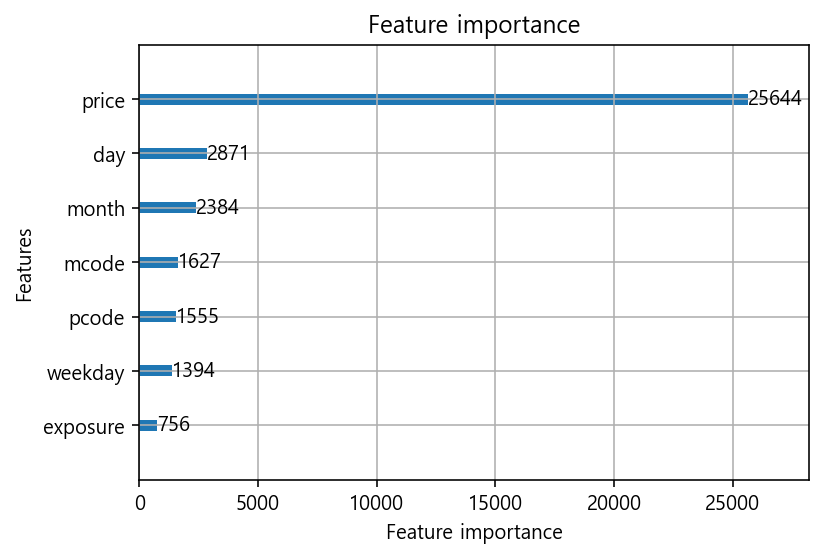

In [16]:
lgb.plot_importance(model)

In [17]:
y_pred = model.predict(X_test)
len(y_pred)

777

In [18]:
mean_absolute_percentage_error(y_test, y_pred)

37.9212285832493

In [19]:
test_data['취급액_예측'] = y_pred
test_data

,month,day,weekday,exposure,mcode,pcode,price,sales,취급액_예측
1960,8,6,6,20.00,100545,201630,38900,31298000.0,4.057965e+07
2704,9,19,1,18.25,100492,201487,49900,71481000.0,6.568189e+07
2127,8,18,4,20.00,100202,200685,55900,28919000.0,5.199578e+07
3471,11,22,0,20.00,100317,201665,49900,241079000.0,5.320355e+07
2366,8,30,0,20.00,100202,200685,55900,26805000.0,4.583693e+07
...,...,...,...,...,...,...,...,...,...
2362,8,29,1,20.00,100167,200579,38900,100719000.0,5.411288e+07
651,2,21,1,20.00,100849,202510,59900,61458000.0,4.109060e+07
1926,8,2,0,20.00,100199,200671,50900,20474000.0,3.817656e+07
3235,11,1,0,20.00,100323,201025,49900,62040000.0,5.524977e+07


### 파라미터 조합 2

In [20]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.574452
[200]	valid_0's mape: 0.555253
[300]	valid_0's mape: 0.537965
[400]	valid_0's mape: 0.522666
[500]	valid_0's mape: 0.5087
[600]	valid_0's mape: 0.496521
[700]	valid_0's mape: 0.485743
[800]	valid_0's mape: 0.475554
[900]	valid_0's mape: 0.467046
[1000]	valid_0's mape: 0.45941
[1100]	valid_0's mape: 0.452584
[1200]	valid_0's mape: 0.446006
[1300]	valid_0's mape: 0.439856
[1400]	valid_0's mape: 0.434551
[1500]	valid_0's mape: 0.430052
[1600]	valid_0's mape: 0.425861
[1700]	valid_0's mape: 0.422011
[1800]	valid_0's mape: 0.418232
[1900]	valid_0's mape: 0.414893
[2000]	valid_0's mape: 0.411973
[2100]	valid_0's mape: 0.409262
[2200]	valid_0's mape: 0.40678
[2300]	valid_0's mape: 0.404532
[2400]	valid_0's mape: 0.402595
[2500]	valid_0's mape: 0.400628
[2600]	valid_0's mape: 0.398878
[2700]	valid_0's mape: 0.397197
[2800]	valid_0's mape: 0.395665
[2900]	valid_0's mape: 0.394325
[3000]	valid_0's mape: 

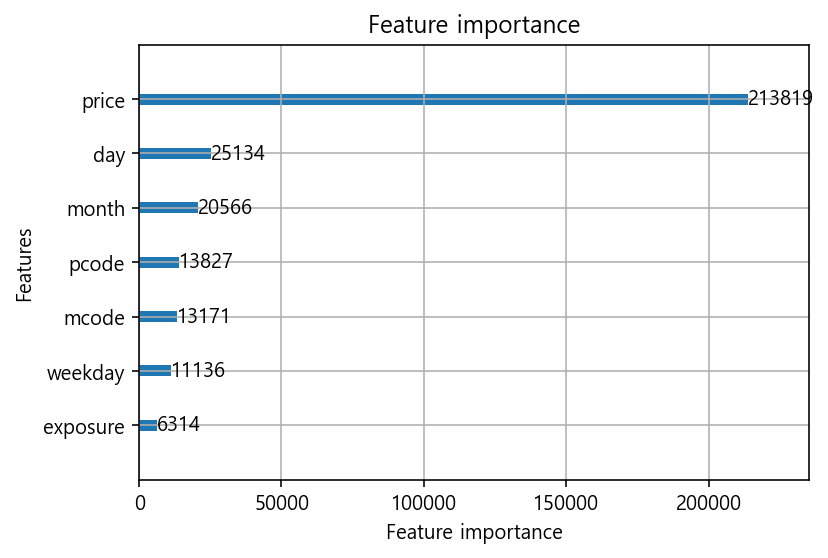

In [21]:
lgb.plot_importance(model)

In [22]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

37.80229195431142

In [23]:
test_data['취급액_예측'] = y_pred
test_data

,month,day,weekday,exposure,mcode,pcode,price,sales,취급액_예측
1960,8,6,6,20.00,100545,201630,38900,31298000.0,3.938514e+07
2704,9,19,1,18.25,100492,201487,49900,71481000.0,6.469930e+07
2127,8,18,4,20.00,100202,200685,55900,28919000.0,5.164127e+07
3471,11,22,0,20.00,100317,201665,49900,241079000.0,5.511645e+07
2366,8,30,0,20.00,100202,200685,55900,26805000.0,4.501500e+07
...,...,...,...,...,...,...,...,...,...
2362,8,29,1,20.00,100167,200579,38900,100719000.0,5.387210e+07
651,2,21,1,20.00,100849,202510,59900,61458000.0,4.086377e+07
1926,8,2,0,20.00,100199,200671,50900,20474000.0,3.763561e+07
3235,11,1,0,20.00,100323,201025,49900,62040000.0,5.483785e+07


### 파라미터 조합 3

In [24]:
params = {'learning_rate': 0.0025, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5,
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.544181
[200]	valid_0's mape: 0.505705
[300]	valid_0's mape: 0.476119
[400]	valid_0's mape: 0.455503
[500]	valid_0's mape: 0.439127
[600]	valid_0's mape: 0.427518
[700]	valid_0's mape: 0.417728
[800]	valid_0's mape: 0.410339
[900]	valid_0's mape: 0.404588
[1000]	valid_0's mape: 0.399273
[1100]	valid_0's mape: 0.395471
[1200]	valid_0's mape: 0.392017
[1300]	valid_0's mape: 0.3886
[1400]	valid_0's mape: 0.386517
[1500]	valid_0's mape: 0.385001
[1600]	valid_0's mape: 0.382836
[1700]	valid_0's mape: 0.381794
[1800]	valid_0's mape: 0.38096
[1900]	valid_0's mape: 0.380472
[2000]	valid_0's mape: 0.380076
[2100]	valid_0's mape: 0.379477
[2200]	valid_0's mape: 0.379403
Early stopping, best iteration is:
[2133]	valid_0's mape: 0.379311


# Feature 선택 2
- 월
- 일
- 요일
- 노출(분)
- ~~마더코드~~
- ~~상품코드~~
- 판매단가

In [25]:
# data['판매량'] = data['취급액'] / data['판매단가']
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액,월,일,요일
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0,1,1,화요일
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0,1,1,화요일
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0,1,1,화요일
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0,1,1,화요일
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0,1,1,화요일
...,...,...,...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0,12,31,화요일
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0,12,31,화요일
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0,12,31,화요일
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0,12,31,화요일


In [26]:
df = data[['월', '일', '요일', '노출(분)', '판매단가', '취급액']]
df.columns = ['month', 'day', 'weekday', 'exposure', 'price', 'sales']
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,month,day,weekday,exposure,price,sales
0,1,1,6,20.0,60900,14113000.0
1,1,1,6,20.0,60900,32395000.0
2,1,1,6,20.0,60900,39669000.0
3,1,1,6,20.0,49900,60787000.0
4,1,1,6,20.0,49900,115457000.0
...,...,...,...,...,...,...
3879,12,31,6,20.0,30900,54879000.0
3880,12,31,6,20.0,30900,63460000.0
3881,12,31,6,20.0,49900,34001000.0
3882,12,31,6,20.0,49900,54234000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   month     3884 non-null   int64  
 1   day       3884 non-null   int64  
 2   weekday   3884 non-null   int32  
 3   exposure  3884 non-null   float64
 4   price     3884 non-null   int64  
 5   sales     3884 non-null   float64
dtypes: float64(2), int32(1), int64(3)
memory usage: 167.0 KB


In [29]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['weekday']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

## 데이터셋 구성

In [30]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [31]:
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

## 파라미터 구성

### 파라미터 조합 1

In [32]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.591581
[200]	valid_0's mape: 0.587041
[300]	valid_0's mape: 0.582779
[400]	valid_0's mape: 0.579432
[500]	valid_0's mape: 0.575736
[600]	valid_0's mape: 0.572668
[700]	valid_0's mape: 0.569575
[800]	valid_0's mape: 0.566902
[900]	valid_0's mape: 0.564642
[1000]	valid_0's mape: 0.56242
[1100]	valid_0's mape: 0.56033
[1200]	valid_0's mape: 0.55863
[1300]	valid_0's mape: 0.556795
[1400]	valid_0's mape: 0.554796
[1500]	valid_0's mape: 0.553126
[1600]	valid_0's mape: 0.551329
[1700]	valid_0's mape: 0.549914
[1800]	valid_0's mape: 0.548603
[1900]	valid_0's mape: 0.547516
[2000]	valid_0's mape: 0.546232
[2100]	valid_0's mape: 0.544814
[2200]	valid_0's mape: 0.543743
[2300]	valid_0's mape: 0.542537
[2400]	valid_0's mape: 0.54152
[2500]	valid_0's mape: 0.540259
[2600]	valid_0's mape: 0.539492
[2700]	valid_0's mape: 0.538319
[2800]	valid_0's mape: 0.537477
[2900]	valid_0's mape: 0.536782
[3000]	valid_0's mape: 

In [34]:
params = {'learning_rate': 0.001, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=1000000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.591289
[200]	valid_0's mape: 0.586762
[300]	valid_0's mape: 0.583032
[400]	valid_0's mape: 0.579926
[500]	valid_0's mape: 0.576839
[600]	valid_0's mape: 0.573897
[700]	valid_0's mape: 0.571151
[800]	valid_0's mape: 0.569028
[900]	valid_0's mape: 0.56672
[1000]	valid_0's mape: 0.564634
[1100]	valid_0's mape: 0.562518
[1200]	valid_0's mape: 0.560951
[1300]	valid_0's mape: 0.559286
[1400]	valid_0's mape: 0.557565
[1500]	valid_0's mape: 0.55621
[1600]	valid_0's mape: 0.55479
[1700]	valid_0's mape: 0.553621
[1800]	valid_0's mape: 0.552133
[1900]	valid_0's mape: 0.550975
[2000]	valid_0's mape: 0.549806
[2100]	valid_0's mape: 0.548709
[2200]	valid_0's mape: 0.547888
[2300]	valid_0's mape: 0.546575
[2400]	valid_0's mape: 0.545715
[2500]	valid_0's mape: 0.544673
[2600]	valid_0's mape: 0.544025
[2700]	valid_0's mape: 0.542901
[2800]	valid_0's mape: 0.541871
[2900]	valid_0's mape: 0.541316
[3000]	valid_0's mape:

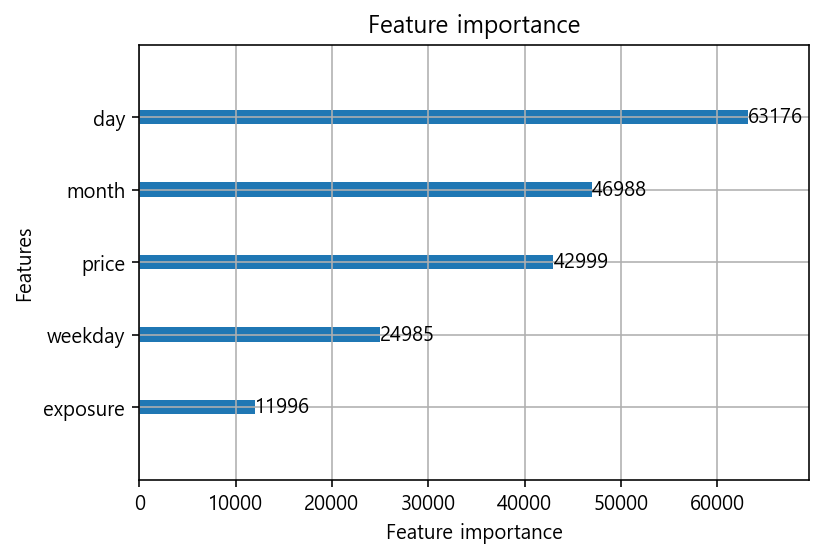

In [35]:
lgb.plot_importance(model)